In [ ]:
import numpy as np
from math import sqrt
import missingno as msno
from tqdm import tqdm
import os

import warnings # 불필요한 경고문 삭제
warnings.filterwarnings(action='ignore')

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime, to_timedelta, date_range

#tensorflow 2.0
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import SGD, Adam, Adamax, Adagrad, RMSprop, Nadam
from keras.layers.advanced_activations import LeakyReLU, PReLU
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:
# 파일 불러오기
df = pd.read_excel('duck.xlsx')

In [ ]:
# 데이터 확인
df

,data:time,C001,C002,C003,C004,C005,C006,C007,C008,강수량,Unnamed: 10
0,2018-11-13 18:00:00,NaN,NaN,29.772457,29.391930,NaN,NaN,29.859067,26.046067,NaN,NaN
1,2018-11-13 18:10:00,NaN,NaN,29.770243,29.377716,NaN,NaN,29.858153,26.043153,NaN,NaN
2,2018-11-13 18:20:00,NaN,NaN,29.770237,29.382110,NaN,NaN,29.855647,26.042447,NaN,NaN
3,2018-11-13 18:30:00,NaN,NaN,29.769605,29.387179,NaN,NaN,29.855415,26.042415,NaN,NaN
4,2018-11-13 18:40:00,NaN,NaN,29.768501,29.390675,NaN,NaN,29.858911,26.044011,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
132326,2021-05-20 16:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132327,2021-05-20 16:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132328,2021-05-20 16:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132329,2021-05-20 16:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132331 entries, 0 to 132330
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   data:time    132331 non-null  datetime64[ns]
 1   C001         85203 non-null   float64       
 2   C002         81059 non-null   float64       
 3   C003         110098 non-null  float64       
 4   C004         109277 non-null  float64       
 5   C005         74587 non-null   float64       
 6   C006         76464 non-null   float64       
 7   C007         35236 non-null   float64       
 8   C008         38317 non-null   float64       
 9   강수량          757 non-null     float64       
 10  Unnamed: 10  1 non-null       float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 11.1 MB


<AxesSubplot:>

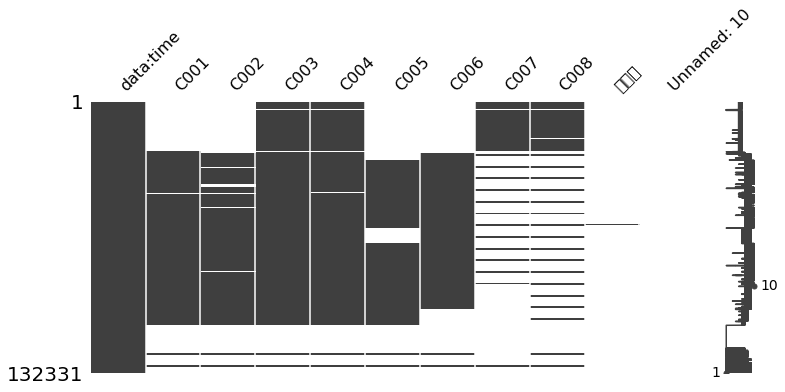

In [ ]:
# 결측값 확인
import missingno as msno

msno.matrix(df, figsize=(12,5))

In [ ]:
# 결측일을 전처리하기 위함

# 날짜 컬럼 설정
_date = df[df.columns[0]]

# 데이터의 시작 시간과 종료 시간을 기준으로 10분 단위 날짜 데이터 생성 
_range = date_range(start = _date[0], end = _date[len(_date)-1], freq='10min')

# 인덱스 설정
df.set_index(df.columns[0],inplace=True)
_df = df.reindex(_range)

In [ ]:
# 정체불명 컬럼 삭제
_df = _df.drop([_df.columns[-1]], axis=1)
_df.rename(columns={'강수량':'rain'})

,C001,C002,C003,C004,C005,C006,C007,C008,rain
2018-11-13 18:00:00,NaN,NaN,29.772457,29.391930,NaN,NaN,29.859067,26.046067,NaN
2018-11-13 18:10:00,NaN,NaN,29.770243,29.377716,NaN,NaN,29.858153,26.043153,NaN
2018-11-13 18:20:00,NaN,NaN,29.770237,29.382110,NaN,NaN,29.855647,26.042447,NaN
2018-11-13 18:30:00,NaN,NaN,29.769605,29.387179,NaN,NaN,29.855415,26.042415,NaN
2018-11-13 18:40:00,NaN,NaN,29.768501,29.390675,NaN,NaN,29.858911,26.044011,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-20 16:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-20 16:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-20 16:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-20 16:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 수위가 모두 null값이 아닌 행들
df[df.columns[:-2]][df[df.columns[:-2]].notnull().sum(1) == 8]

,C001,C002,C003,C004,C005,C006,C007,C008
data:time,,,,,,,,
2019-05-31 03:00:00,23.600042,22.653823,27.431042,27.542716,26.467852,26.484808,27.54,23.64
2019-05-31 04:00:00,23.607723,22.859003,27.441623,27.559196,26.503603,26.509389,27.56,23.65
2019-05-31 05:00:00,23.479363,22.631544,27.448463,27.571037,26.536038,26.521729,27.57,23.60
2019-05-31 06:00:00,23.501642,22.448923,27.452542,27.530015,26.555468,26.429808,27.57,23.57
2019-05-31 07:00:00,23.532391,22.489172,27.454691,27.512465,26.548488,26.410757,27.56,23.59
...,...,...,...,...,...,...,...,...
2021-05-20 13:00:00,24.990000,22.710000,29.050000,29.090000,26.420000,27.960000,26.28,24.00
2021-05-20 14:00:00,24.980000,22.600000,29.060000,29.100000,26.440000,27.960000,26.29,24.00
2021-05-20 15:00:00,24.960000,22.580000,29.060000,29.100000,26.450000,27.940000,26.29,23.99


In [ ]:
# 수위가 모두 null값인 행들
_df.iloc[:, :-1][_df[_df.columns[:-1]].isnull().sum(1) == 8]

,C001,C002,C003,C004,C005,C006,C007,C008
2018-12-11 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-11 09:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-11 09:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-11 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-11 10:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-05-20 16:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-20 16:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-20 16:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-20 16:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i in _df.columns:
  print(i, '기록 시작 시각 :', _df[_df[i].notnull()].index[0])

C001 기록 시작 시각 : 2019-05-02 20:50:00
C002 기록 시작 시각 : 2019-05-09 21:20:00
C003 기록 시작 시각 : 2018-11-13 18:00:00
C004 기록 시작 시각 : 2018-11-13 18:00:00
C005 기록 시작 시각 : 2019-05-30 10:20:00
C006 기록 시작 시각 : 2019-05-09 21:20:00
C007 기록 시작 시각 : 2018-11-13 18:00:00
C008 기록 시작 시각 : 2018-11-13 18:00:00
강수량 기록 시작 시각 : 2018-11-14 00:00:00


In [ ]:
# 10분 단위 기록
__df = _df.reset_index()
for i in __df.columns[1:9]:
  __df['index2'] = __df[__df[i].notnull() == True][['index']].shift(-1)
  __df['index3'] = __df[__df[i].notnull() == True][['index']].shift(-2)
  print(f'{i}의 1시간 단위 변환 시작 시각 :', pd.Timestamp(__df[(__df['index2'] - __df['index'] == pd.Timedelta(hours=1)) & (__df['index3'] - __df['index2'] == pd.Timedelta(hours=1))]['index'].values[0]))

C001의 1시간 단위 변환 시작 시각 : 2021-02-24 09:00:00
C002의 1시간 단위 변환 시작 시각 : 2021-02-24 09:00:00
C003의 1시간 단위 변환 시작 시각 : 2021-02-24 10:00:00
C004의 1시간 단위 변환 시작 시각 : 2021-02-24 10:00:00
C005의 1시간 단위 변환 시작 시각 : 2021-02-24 09:00:00
C006의 1시간 단위 변환 시작 시각 : 2021-02-24 09:00:00
C007의 1시간 단위 변환 시작 시각 : 2019-05-04 10:00:00
C008의 1시간 단위 변환 시작 시각 : 2019-05-04 10:00:00


In [ ]:
# 음의 값을 절대값으로 변환
for i in __df.columns[1:9]:
    if min(__df[i].values) < 0:
        for j in __df[__df[i] < 0].index:
            __df.loc[j, i] = abs(__df.loc[j, i])

In [ ]:
# 1시간 단위 데이터 프레임을 만들기 위함
trans_df_h = pd.DataFrame()

# 1일 단위 데이터 프레임을 만들기 위함
trans_df = pd.DataFrame()

In [ ]:
# 1시간 단위로 변환
__df['강수량'] = __df['강수량'].fillna(0)
for j, i in tqdm(enumerate(__df.groupby(by = [__df['index'].dt.year, __df['index'].dt.month, __df['index'].dt.day, __df['index'].dt.hour]))):
  # 날짜 인식 이상으로 str 변환 후 잘라내기
  trans_df_h.loc[j, 'date'] = to_datetime(str(i[0][0]) + '-' + str(i[0][1]) + '-' + str(i[0][2]) + ' ' + str(i[0][3]).zfill(2), format='%Y-%m-%d %H')
  for k in __df.columns[1:9]:
      try:
        trans_df_h.loc[j, k] = sum(i[1][k][i[1][k].notnull()])/len(i[1][k][i[1][k].notnull()])
      except:
        trans_df_h.loc[j, k] = np.nan
  trans_df_h.loc[j, 'rain'] = sum(i[1]['강수량'].values)

22056it [03:53, 94.35it/s] 


In [ ]:
# 1일 단위로 변환
for j, i in tqdm(enumerate(trans_df_h.groupby(by = [trans_df_h.date.dt.year, trans_df_h.date.dt.month, trans_df_h.date.dt.day]))):
  # 날짜 인식 이상으로 str 변환 후 잘라내기
  trans_df.loc[j, '_date'] = to_datetime(str(i[0][0]) + '-' + str(i[0][1]) + '-' + str(i[0][2]), format='%Y-%m-%d')
  for k in trans_df_h.columns[1:9]:
    try:
      trans_df.loc[j, k] = sum(i[1][k][i[1][k].notnull()])/len(i[1][k][i[1][k].notnull()])
    except:
      trans_df.loc[j, k] = np.nan
  trans_df.loc[j, 'rain'] = sum(i[1]['rain'].values)

920it [00:08, 103.92it/s]


In [ ]:
# 변환 데이터
trans_df

,_date,C001,C002,C003,C004,C005,C006,C007,C008,rain
0,2018-11-13,NaN,NaN,29.762949,29.374598,NaN,NaN,29.857251,26.035976,0.0
1,2018-11-14,NaN,NaN,29.753466,29.450510,NaN,NaN,29.855676,26.032637,0.0
2,2018-11-15,NaN,NaN,29.764339,29.542585,NaN,NaN,29.873859,25.936289,0.0
3,2018-11-16,NaN,NaN,29.853032,29.654344,NaN,NaN,29.973508,25.297936,0.0
4,2018-11-17,NaN,NaN,29.841348,29.599985,NaN,NaN,29.936141,25.352791,0.0
...,...,...,...,...,...,...,...,...,...,...
915,2021-05-16,24.932500,23.162083,29.016667,29.032500,26.361667,27.877500,26.406667,26.200000,0.0
916,2021-05-17,24.946667,23.171250,28.971250,28.995000,26.299167,27.853750,26.380833,NaN,0.0
917,2021-05-18,24.987917,23.204583,28.965000,29.001667,26.289583,27.875417,26.325833,23.910000,0.0
918,2021-05-19,25.013333,23.225000,28.994167,29.024583,26.325000,27.917917,26.277500,23.983750,0.0


In [ ]:
# 파일 저장 함수
def save(file):
  file.to_csv("/Users/junei/SODA/20210705/result_saved" + ".csv",header=True,index=False)
  print("결과값이 저장되었습니다.")

In [ ]:
# 불안한 마음에 파일 저장
save(trans_df)

결과값이 저장되었습니다.


In [ ]:
# 동일 파일 불러오기
trans_df = pd.read_csv('result_saved.csv', encoding = 'euc-kr', parse_dates=['_date'])

In [ ]:
# 관측소별 데이터 프레임 생성
for i in trans_df.columns[1:9]:
  globals() [f'df_{i}'] = trans_df[['_date', i, 'rain']].reset_index(drop = True)

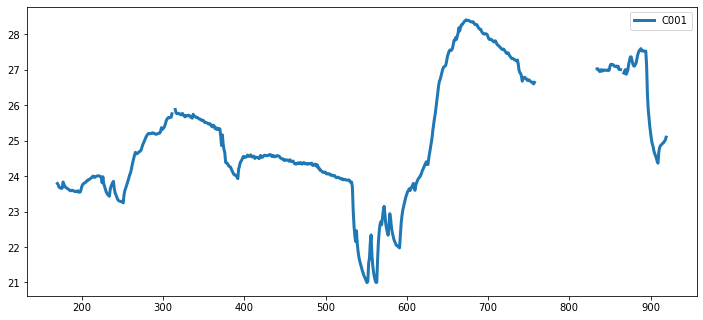

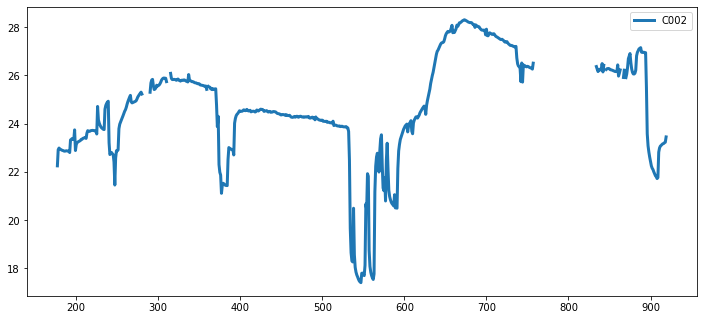

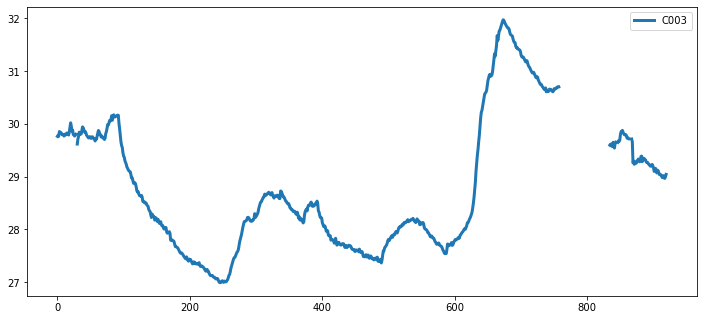

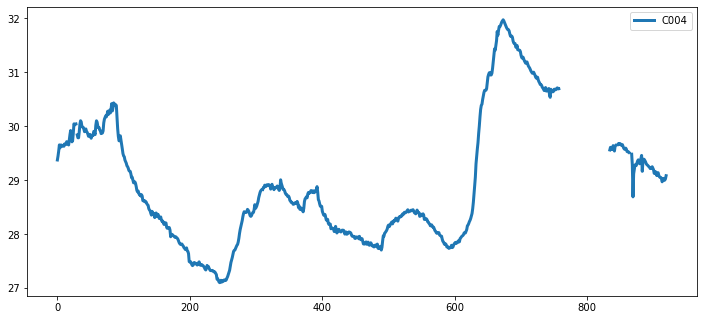

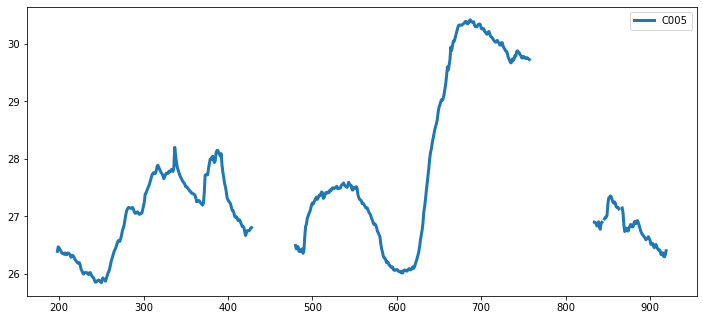

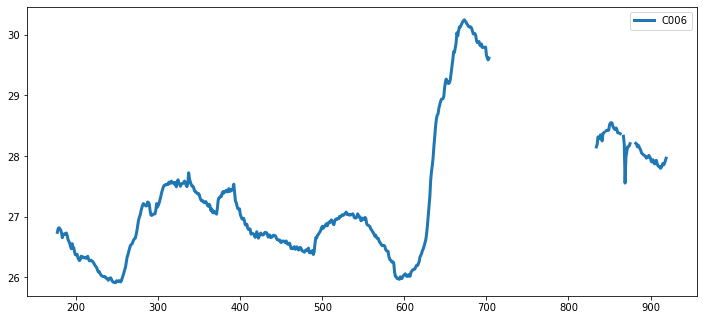

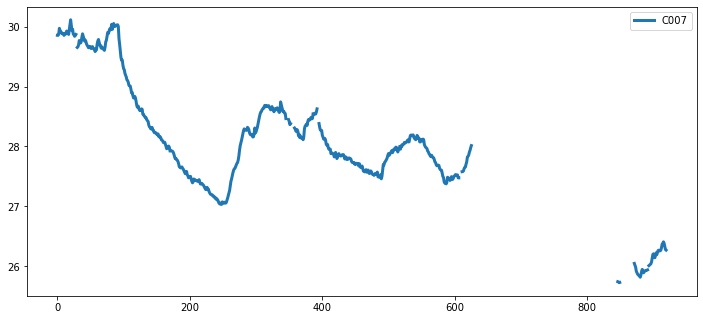

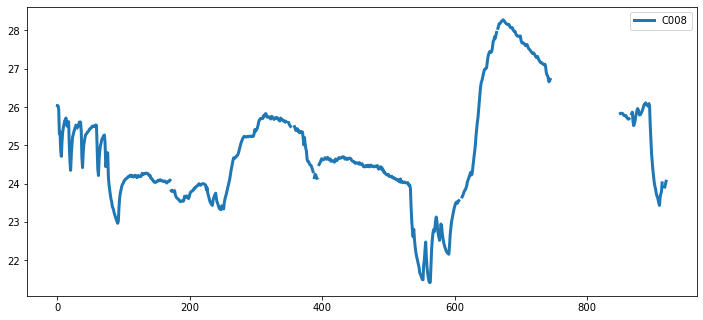

In [ ]:
# 관측공 별 결측값 확인
for i in range(1, 9):
  plt.figure(figsize=[12,50]).add_subplot(8, 1, i)
  plt.plot(trans_df[trans_df.columns[i]], label=f'C00{i}', linewidth=3)
  plt.legend()
  plt.show()

<AxesSubplot:>

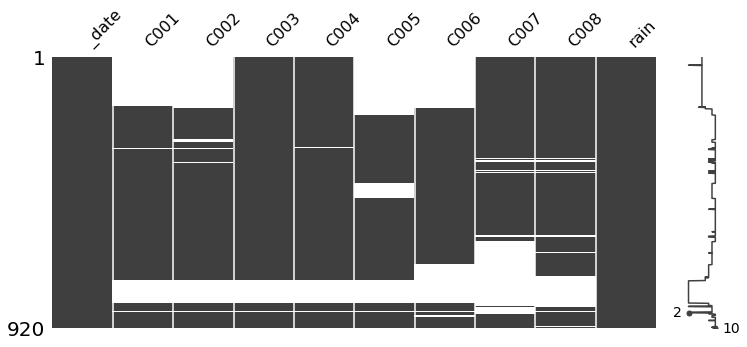

In [ ]:
# 변환 데이터
msno.matrix(trans_df, figsize=(12,5))

In [ ]:
df_C001[df_C001['C001'].isnull()].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            829, 830, 831, 832, 833, 844, 845, 864, 865, 866],
           dtype='int64', length=254)

In [ ]:
# 관측공 별 데이터에서 null값과 아닌 값을 구획하기
def data_term(k):
    null_ = [j for j in trans_df[trans_df[k].isnull()].index]
    data_ = [i for i in trans_df[trans_df[k].notnull()].index]

    print(f"==========\n{k}의 기록 데이터\n==========\n")

    for i in null_:
      if i+1 in data_:
        print("데이터 시작 :", i+1, to_datetime(trans_df.loc[(i + 1), '_date']))
      if i-1 in data_:
        print("데이터 끝 :", i-1, to_datetime(trans_df.loc[(i - 1), '_date']), '\n')

각 관측소 별로 df만들고, 합치기

In [ ]:
# 날짜 기준
def term(k):
  # null과 아닌 데이터의 인덱스
  _null = [j for j in trans_df[trans_df[k].isnull()].index]
  _data = [i for i in trans_df[trans_df[k].notnull()].index]  

  # 데이터가 시작하는, 끝나는 인덱스 리스트
  _start = [trans_df.loc[_data[0], '_date']]
  _finish = []

  # null 데이터의 인덱스의
  for i in _null:
    # +1한 인덱스가 아닌 데이터의 인덱스에 있다면
    if i+1 in _data:
      # 그런데 그 값이 start의 첫 값과 같으면 패스 
      if trans_df.loc[i + 1, '_date'] == _start[0]:
        pass
      # 아니라면 start 리스트에 추가해준다.(null이 끝나고 새롭게 데이터가 시작하는 인덱스)
      else:
        _start.append(trans_df.loc[i + 1, '_date'])
    # -i한 인덱스가 null이 아닌 데이터의 인덱스 리스트에 있다면 추가해준다.(데이터가 끝나는 인덱스)
    if i-1 in _data:
      _finish.append(trans_df.loc[i - 1, '_date'])

  # 데이터가 있는 값의 마지막 인덱스를 끝나는 인덱스 리스트에 추가해준다.
  _finish.append(trans_df.loc[_data[-1], '_date'])

  # 시작, 끝 데이터 프레임과 컬럼을 만들어준다.
  s_df = pd.DataFrame()
  s_df[f'{k}_start'] = _start
  f_df = pd.DataFrame()
  f_df[f'{k}_finish'] = _finish

  a_df = pd.concat([s_df, f_df], axis=1)

  # 데이터가 있는 기간을 계산한다.
  a_df[f'{k}_term'] = a_df[f'{k}_finish'] - a_df[f'{k}_start']

  # null 기간을 계산한다.
  for i in a_df.index:
    try:
      null_term = a_df.loc[i + 1, f'{k}_start'] - a_df.loc[i, f'{k}_finish'] - pd.Timedelta('1 days')
      if null_term == np.datetime64:
        continue
      else:
        a_df.loc[i, f'{k}_null'] = null_term

    except:
      pass

  # 최종 데이터 프레임 반환
  return a_df

In [ ]:
date_df = pd.DataFrame()

for k in trans_df.columns[1:9]:
  date_df = pd.concat([date_df, term(k)], axis=1)

# 관측공 별 데이터 시작, 끝, null기간, 아닌 기간의 정보
display(date_df)

,C001_start,C001_finish,C001_term,C001_null,C002_start,C002_finish,C002_term,C002_null,C003_start,C003_finish,...,C006_term,C006_null,C007_start,C007_finish,C007_term,C007_null,C008_start,C008_finish,C008_term,C008_null
0,2019-05-02,2019-09-20,141 days,3 days,2019-05-09,2019-08-20,103 days,9 days,2018-11-13,2018-12-11,...,526 days,130 days,2018-11-13,2018-12-11,28 days,1 days,2018-11-13,2018-12-11,28 days,1 days
1,2019-09-24,2020-12-09,442 days,76 days,2019-08-30,2019-09-19,20 days,4 days,2018-12-13,2020-12-09,...,9 days,2 days,2018-12-13,2019-05-02,140 days,1 days,2018-12-13,2019-05-02,140 days,1 days
2,2021-02-24,2021-03-05,9 days,2 days,2019-09-24,2019-11-07,44 days,1 days,2021-02-24,2021-03-05,...,17 days,3 days,2019-05-04,2019-10-24,173 days,1 days,2019-05-04,2019-10-24,173 days,1 days
3,2021-03-08,2021-03-25,17 days,3 days,2019-11-09,2020-12-09,396 days,76 days,2021-03-08,2021-03-25,...,8 days,6 days,2019-10-26,2019-10-26,0 days,1 days,2019-10-26,2019-10-26,0 days,1 days
4,2021-03-29,2021-05-20,52 days,NaT,2021-02-24,2021-03-05,9 days,2 days,2021-03-29,2021-05-20,...,37 days,NaT,2019-10-28,2019-10-31,3 days,5 days,2019-10-28,2019-10-31,3 days,5 days
5,NaT,NaT,NaT,NaT,2021-03-08,2021-03-25,17 days,3 days,NaT,NaT,...,NaT,NaT,2019-11-06,2019-12-04,28 days,1 days,2019-11-06,2019-12-04,28 days,1 days
6,NaT,NaT,NaT,NaT,2021-03-29,2021-03-30,1 days,1 days,NaT,NaT,...,NaT,NaT,2019-12-06,2019-12-10,4 days,2 days,2019-12-06,2019-12-10,4 days,2 days
7,NaT,NaT,NaT,NaT,2021-04-01,2021-05-20,49 days,NaT,NaT,NaT,...,NaT,NaT,2019-12-13,2020-04-11,120 days,1 days,2019-12-13,2020-04-11,120 days,1 days
8,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,2020-04-13,2020-06-26,74 days,1 days,2020-04-13,2020-07-11,89 days,4 days
9,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,2020-06-28,2020-07-11,13 days,4 days,2020-07-16,2020-09-06,52 days,1 days


In [ ]:
# C001 : 2019-05-02 ~ 2020-12-09
# C002 : 2019-05-09 ~ 2020-12-09
# C003 : 2018-11-13 ~ 2020-12-09
# C004 : 2018-11-13 ~ 2020-12-09
# C005 : 2019-05-30 ~ 2020-12-09
# C006 : 2019-05-09	~ 2020-10-16
# C007 : 2018-11-13 ~ 2020-07-30
# C008 : 2018-11-13 ~ 2020-11-29

In [ ]:
def dict_to_frame(metrics_dict):
    # 성능 비교를 위해 metrics를 리스트로 만들고, dataframe의 컬럼명으로 만듦
    column_list = [str(i).split(' ')[1] for i in metrics]

    # 딕셔너리 형태로 저장되어 있는 모델 별 metrics를 리스트로 만듦
    index_list = list(metrics_dict.keys())

    # 설정된 리스트들을 이용해, 데이터 프레임 생성
    metrics_frame = DataFrame(metrics_dict.values(), index = list(metrics_dict.keys()), columns = column_list)

    print(spot + ' metrics comparing')
    
    # 저장 및 출력
    return metrics_frame, display(metrics_frame), display(metrics_frame.sort_values(by=column_list[0])), display(metrics_frame.sort_values(by=column_list[1], ascending = False))

In [ ]:
def cal_metrics(fit_test, zhat, saved_name, metrics_dict, nname=''):
    # 다른 함수에서도 사용해야하기 때문에 global 변수로 설정
    global metrics

    # 기존의 mean_squared_error와 r2_score를 사용하였지만, 다른 metrics들을 사용하거나 추가하여도 됨.                    
    metrics = [mean_squared_error, r2_score]

    # 모델명 및 metrics 출력
    print('='*150 + '\n' + saved_name + ' ' + spot + ' metrics\n' + '='*150)

    # metrics 딕셔너리 key, list 생성
    metrics_dict[f'{nname} {saved_name}'] = []

    for i in metrics:

        # mean_squared_error는 단순 불러오기가 아닌 한 번 더 계산을 해줘야하기 때문에 따로 설정
        if i is mean_squared_error:
              cald_metric = sqrt(mean_squared_error(fit_test, zhat))
              metrics_dict[f'{nname} {saved_name}'].append(cald_metric)

              # 모델별 계산된 metrics 출력
              print(str(i).split(' ')[1], ':', cald_metric)

        else:
              # metrics 계산
              cald_metric = i(fit_test, zhat)
              metrics_dict[f'{nname} {saved_name}'].append(cald_metric)

              # 모델별 계산된 metrics 출력
              print(str(i).split(' ')[1], ':', cald_metric)

    print('='*150 + '\n' + saved_name + '이 완료되었습니다.\n' + '='*150)

In [ ]:
def model_prediction(test_X, test, model, saved_name, metrics_dict, nname=''): 
    # 예측, 예측값(zhat)
    zhat = model.predict(test_X)

    # 실제값
    fit_test = test[:, -1]

    print("\n", saved_name, "데이터 비교")

    # 그래프 크기 설정
    pyplot.figure(figsize=[12, 6])

    # 실제 데이터 그래프
    pyplot.plot(fit_test.ravel(), 'r-', label='actual')

    # 예측 데이터 그래프
    pyplot.plot(zhat.ravel(), 'b-', label='prediction')

    # 레이블 출력
    pyplot.legend()

    # 그래프 출력
    pyplot.show()

    fit_test = fit_test.reshape((fit_test.shape[0], 1))
    zhat = zhat.reshape((zhat.shape[0], 1))
    print('='*150 + '\n' + saved_name + ' model_prediction이 완료되었습니다.\n' + '='*150)
    cal_metrics(fit_test, zhat, saved_name, metrics_dict, nname)

    # 예측값 반환
    return zhat

In [ ]:
def plot_history(test_X, test, history, model, saved_name, metrics_dict):
  # 그래프 크기
  pyplot.figure(figsize=[12, 6])

  # 훈련 데이터 loss값 곡선 (학습이 진행되면서, 원본값과 예측값이 얼마나 차이를 보이는 가를 표현)
  pyplot.plot(history.history['loss'], label='train')

  pyplot.plot(history.history['val_loss'], label= 'test') # 검증 데이터 loss값 곡선 (val_loss는 'validation loss'로, 검증데이터의 loss값을 말함)
  
  # 그래프 제목
  pyplot.title(saved_name + " LOSS")
  
  # 레이블 출력
  pyplot.legend()

  # 그래프 출력
  pyplot.show()

  return model_prediction(test_X, test, model, saved_name, metrics_dict)

In [ ]:
def fit_model(train_X, train_y, valid_X, valid_y, test_X, test, model, saved_name, metrics_dict):
    # early_stopping 사용 (과적합 방지를 위해 일정 이상 학습이 되었을 경우, 학습을 정지)
    early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1) # mode='min', patience=5, verbose=1)

    # 훈련데이터와 검증데이터에 모델 적용
    history = model.fit(train_X, train_y, epochs=200, batch_size=50, validation_data=(valid_X, valid_y), verbose=2, shuffle=False) # , callbacks=[early_stop])

    # 모델 저장
    model.save('/content/drive/MyDrive/soda/models/test/{0}/{1}/'.format(spot, str(n_shift)) + saved_name + '.h5')
    print('='*150 + '\nmodel ' + saved_name  + "가 저장되었습니다.\n" + '='*150)

    plot_history(test_X, test, history, model, saved_name, metrics_dict)

In [ ]:
def model_settings(scaler_name, metrics_dict, train_X, train_y, valid_X, valid_y, test_X, test):
    # optimizers 설정. 추가 또는 제외 가능
    optimizers = [Adamax, SGD] # ,Adagrad] # ] # , RMSprop, Nadam, Adam] 

    # 활성함수 설정. 추가 또는 제외 가능
    activations1 = ['relu'] # , 'sigmoid', 'tanh']
    activations2 = ['linear']
    relu_activations = [] # [LeakyReLU()] # [PReLU(), ]

    # 손실함수 설정
    losses = ['mse'] # ,'mae', 'mape']

    # 모델 설정
    for j in (activations1 + relu_activations):
    # 사용될 활성함수 출력 및 설정
        if j in activations1: optimizer_name = j
        else: optimizer_name = j.name
        for k in activations2:
            for l in losses:
                for i in optimizers:

                    # 시퀀스 모델
                    model = Sequential()
                    print("LSTM activation :", optimizer_name)
                    # 모델에 설정을 추가 : model.add(사용 알고리즘(한 층당 셀 수, 활성함수, 입력 데이터 모양, 층을 추가할 것인지))
                    model.add(LSTM(90, activation = j,input_shape=(train_X.shape[1], train_X.shape[2]))) # , return_sequences = True))

                    # 과적합 방지를 위해 학습중 일부 데이터를 제외시킴
                    model.add(Dropout(0.2))

                    # 층을 추가할 경우, 다음 층 (주석을 지우고 사용)
                    # model.add(LSTM(30, activation = j, return_sequences = False))

                    # 출력값의 활성함수 출력 및 설정
                    print("Dense activation :", k)
                    model.add(Dense(train_y.shape[1], activation = k))

                    # 손실함수 출력 및 설정
                    print("loss :", l)
                    print("optimizer :", str(i).split('.')[-2])
                    # clipnorm(그래디언트 클리핑)은 써도 되고 안 써도 됨...(예측값이 좋지 못할 때 기울기를 보정해주는 것)
                    optimizer = i(clipvalue=0.5, clipnorm=1.0)

                    # 모델 설정 취합 및 출력
                    model.compile(loss=l, optimizer=optimizer, metrics=['acc'])
                    model.summary()

                    # 모델이 저장될 이름
                    saved_name = modelname + '_' + str(n_shift) + '_' + scaler_name + '_' + optimizer_name + '_' + str(k) + '_' + str(l) + '_' + str(i).split('.')[-2]

                    fit_model(train_X, train_y, valid_X, valid_y, test_X, test, model, saved_name, metrics_dict)

                    # 딥러닝 모델은 이전의 학습을 기억하고 새로운 층을 쌓기 때문에 초기화 시키고 새로 학습시켜야 함
                    K.clear_session()
                    model.reset_states()

In [ ]:
def scaler_data(train, valid, test):
    metrics_dict = {}

    # 사용할 스케일러 설정
    scalers = [Normalizer(), MaxAbsScaler(), RobustScaler(), MinMaxScaler(), StandardScaler()]
    for scaler_name in scalers:
        scaler = scaler_name
        train = scaler.fit_transform(train)
        valid = scaler.transform(valid)
        # test = scaler.transform(test)

        # 훈련데이터(train), 검증데이터(test), 예측데이터(act)로 분리
        train_X, train_y = train[:, :-1], train[:, -1]
        valid_X, valid_y = valid[:, :-1], valid[:, -1]
        test_X = test[:, :-1]

        # 3D 형태로 reshape [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        train_y = train_y.reshape((train_y.shape[0], 1))
        valid_y = valid_y.reshape((valid_y.shape[0], 1))

        # 학습, 검증, 예측 데이터 형태 출력
        print('train_X.shape :', train_X.shape, '\ntrain_y.shape :', train_y.shape, '\nvalid_X.shape : ', valid_X.shape, '\nvalid_y.shape :', valid_y.shape, '\ntest_X.shape : ', test_X.shape) # , '\ntest_y.shape :', test_y.shape, '\nact_X.shape :', act_X.shape)

        # 스케일러 이름만 추출
        scaler_name = str(scaler_name)[:str(scaler_name).find('(')]

        print('='*150 + '\nscaler_data가 완료되었습니다.\n' + '='*150)
        print('\nScaler :', scaler_name)

        model_settings(scaler_name, metrics_dict, train_X, train_y, valid_X, valid_y, test_X, test)

    dict_to_frame(metrics_dict)

In [ ]:
# 데이터 크기가 작을 경우 s_size를 사용할 것(검증 데이터를 따로 빼지 않는다)
def split_data(train_df, test_df):

  # dataframe 형태에서 값만 추출
    train = train_df.values
    test = test_df.values

    split_size = int(len(train) * 0.8)
#    split_size2 = int(split_size * 0.8)
    
    _train = train[:split_size, :-1]
    _valid = test[:, :-1]
    _test = train[split_size:, :-1]
    # _valid = _train[split_size2:, :]
    # _train = _train[:split_size2, :]

    print('='*150 + '\nsplit_data가 완료되었습니다.\n' + '='*150)

    return scaler_data(_train, _valid, _test)

In [ ]:
def shift_data(df, df_cols, dropnan=True):
    # dataframe으로 변환
    df = pd.DataFrame(df)

    # 컬럼 및 컬럼명 설정  
    cols, names = list(), list()

    # 데이터 shift
    for i in range(n_shift):
    # 기존 데이터 원본 추가
        if i == 0:
            cols.append(df)
            names += [j for j in df_cols]
        # 이후는 shift해서 추가
        else:
          # shift해서 추가
            cols.append(df.shift(-i))
          # 컬럼명 설정
            names += [j + '_' + str(i) for j in df_cols]

    # shift한 데이터들 합치고, 컬럼명 설정
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # shift로 생성된 null값 drop
    if dropnan:
        agg.dropna(inplace=True)

    print('='*150 + "\nshift_data가 완료되었습니다.\n" + '='*150)

    display(agg, agg.info())

    # shift 결과 반환
    return agg

In [ ]:
def set_params(df):
  # shift 전 컬럼 추출
  df_cols = df.columns

  # 데이터 값만 추출
  df = df.values

  # 데이터 타입 설정
  df = df.astype('float32')
    
  return shift_data(df, df_cols)

In [ ]:
n_shift = 2
modelname = 'sw'

shift_data가 완료되었습니다.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 587 entries, 0 to 586
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C001    587 non-null    float32
 1   rain    587 non-null    float32
 2   C001_1  587 non-null    float32
 3   rain_1  587 non-null    float32
dtypes: float32(4)
memory usage: 13.8 KB


,C001,rain,C001_1,rain_1
0,23.791542,0.0,23.755781,0.0
1,23.755781,0.0,23.686699,0.0
2,23.686699,0.0,23.676960,0.0
3,23.676960,0.0,23.661596,0.0
4,23.661596,0.0,23.651531,0.0
...,...,...,...,...
582,26.677942,0.0,26.659512,0.0
583,26.659512,0.0,26.651854,0.0
584,26.651854,0.0,26.629740,0.0
585,26.629740,0.0,26.603418,0.0


None

shift_data가 완료되었습니다.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C001    85 non-null     float32
 1   rain    85 non-null     float32
 2   C001_1  85 non-null     float32
 3   rain_1  85 non-null     float32
dtypes: float32(4)
memory usage: 2.0 KB


,C001,rain,C001_1,rain_1
0,27.030001,0.0,27.032084,0.0
1,27.032084,0.0,26.995218,0.0
2,26.995218,0.0,26.956249,0.0
3,26.956249,0.0,26.959999,0.0
4,26.959999,0.0,27.004999,0.0
...,...,...,...,...
80,24.904583,0.0,24.932501,0.0
81,24.932501,0.0,24.946667,0.0
82,24.946667,0.0,24.987917,0.0
83,24.987917,0.0,25.013334,0.0


None

split_data가 완료되었습니다.
train_X.shape : (469, 1, 2) 
train_y.shape : (469, 1) 
valid_X.shape :  (85, 1, 2) 
valid_y.shape : (85, 1) 
test_X.shape :  (118, 1, 2)
scaler_data가 완료되었습니다.

Scaler : Normalizer
LSTM activation : relu
Dense activation : linear
loss : mse
optimizer : adamax
Model: "sequential_408"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_408 (LSTM)              (None, 90)                33480     
_________________________________________________________________
dropout_384 (Dropout)        (None, 90)                0         
_________________________________________________________________
dense_408 (Dense)            (None, 1)                 91        
Total params: 33,571
Trainable params: 33,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10/10 - 1s - loss: 0.4235 - acc: 0.0000e+00 - val_loss: 0.4182 - val_acc: 0.0000e+00
E

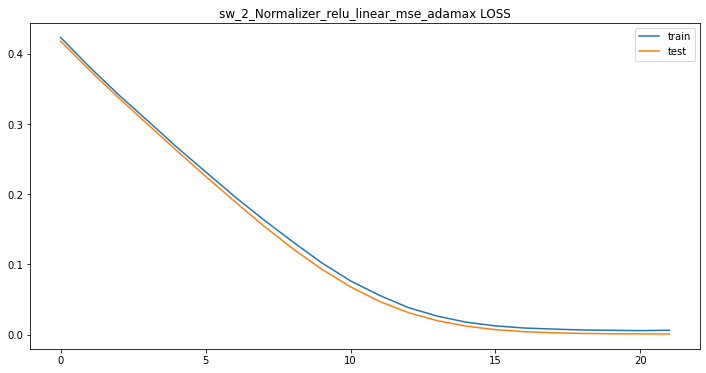


 sw_2_Normalizer_relu_linear_mse_adamax 데이터 비교


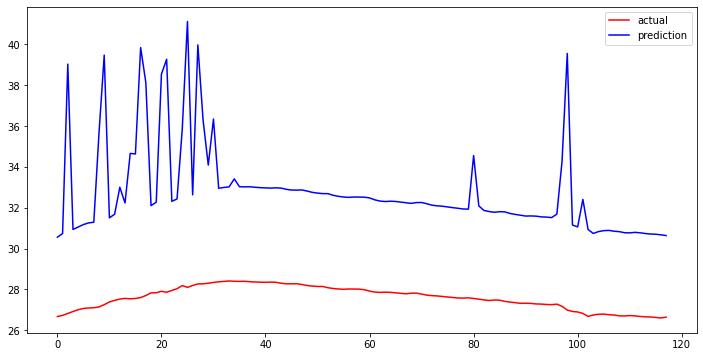

sw_2_Normalizer_relu_linear_mse_adamax model_prediction이 완료되었습니다.
sw_2_Normalizer_relu_linear_mse_adamax C001 metrics
mean_squared_error : 5.599096886155102
r2_score : -99.72152216718555
sw_2_Normalizer_relu_linear_mse_adamax이 완료되었습니다.
LSTM activation : relu
Dense activation : linear
loss : mse
optimizer : gradient_descent
Model: "sequential_409"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_409 (LSTM)              (None, 90)                33480     
_________________________________________________________________
dropout_385 (Dropout)        (None, 90)                0         
_________________________________________________________________
dense_409 (Dense)            (None, 1)                 91        
Total params: 33,571
Trainable params: 33,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10/10 - 1s - loss: 0.3937 - acc: 0.0000e+

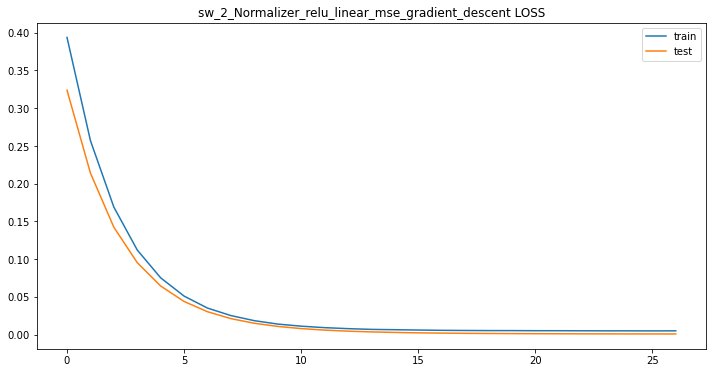


 sw_2_Normalizer_relu_linear_mse_gradient_descent 데이터 비교


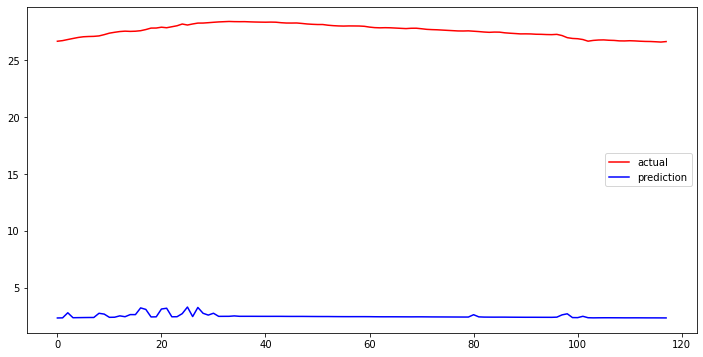

sw_2_Normalizer_relu_linear_mse_gradient_descent model_prediction이 완료되었습니다.
sw_2_Normalizer_relu_linear_mse_gradient_descent C001 metrics
mean_squared_error : 25.11073862585363
r2_score : -2024.8407320794865
sw_2_Normalizer_relu_linear_mse_gradient_descent이 완료되었습니다.
train_X.shape : (469, 1, 2) 
train_y.shape : (469, 1) 
valid_X.shape :  (85, 1, 2) 
valid_y.shape : (85, 1) 
test_X.shape :  (118, 1, 2)
scaler_data가 완료되었습니다.

Scaler : MaxAbsScaler
LSTM activation : relu
Dense activation : linear
loss : mse
optimizer : adamax
Model: "sequential_410"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_410 (LSTM)              (None, 90)                33480     
_________________________________________________________________
dropout_386 (Dropout)        (None, 90)                0         
_________________________________________________________________
dense_410 (Dense)            (None, 1)              

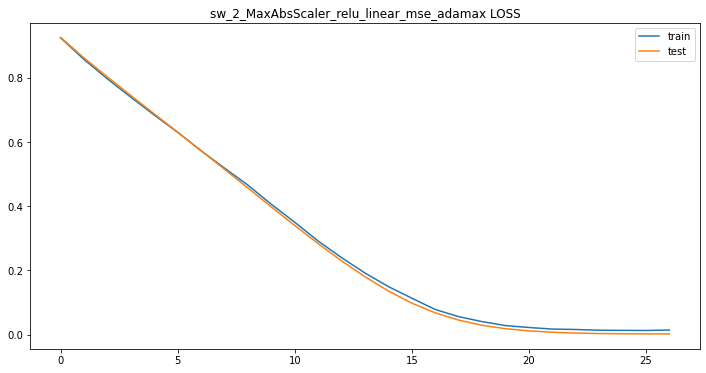


 sw_2_MaxAbsScaler_relu_linear_mse_adamax 데이터 비교


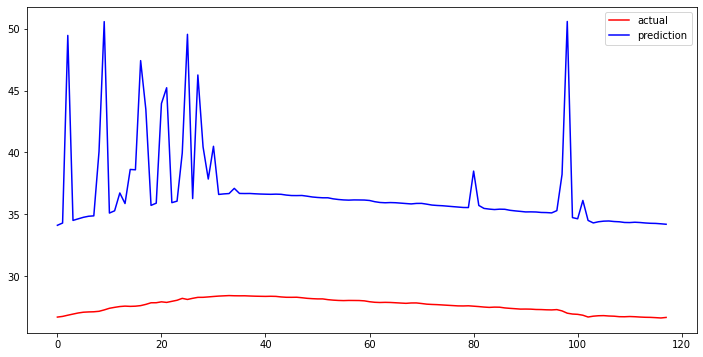

sw_2_MaxAbsScaler_relu_linear_mse_adamax model_prediction이 완료되었습니다.
sw_2_MaxAbsScaler_relu_linear_mse_adamax C001 metrics
mean_squared_error : 9.738906026262853
r2_score : -303.7240128594754
sw_2_MaxAbsScaler_relu_linear_mse_adamax이 완료되었습니다.
LSTM activation : relu
Dense activation : linear
loss : mse
optimizer : gradient_descent
Model: "sequential_411"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_411 (LSTM)              (None, 90)                33480     
_________________________________________________________________
dropout_387 (Dropout)        (None, 90)                0         
_________________________________________________________________
dense_411 (Dense)            (None, 1)                 91        
Total params: 33,571
Trainable params: 33,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10/10 - 1s - loss: 0.7436 - acc: 0.

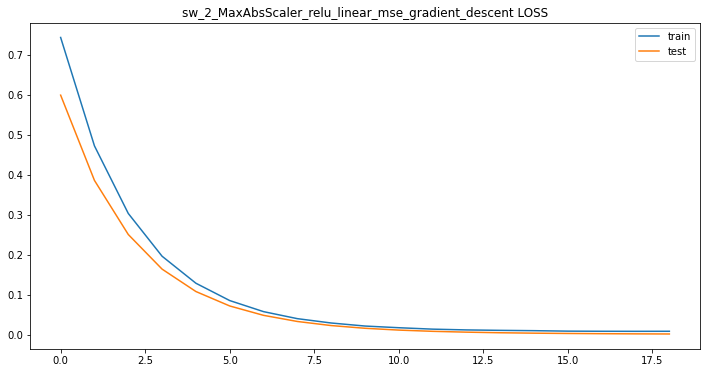


 sw_2_MaxAbsScaler_relu_linear_mse_gradient_descent 데이터 비교


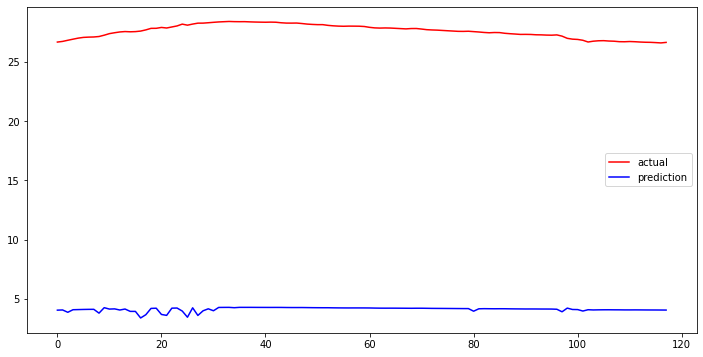

sw_2_MaxAbsScaler_relu_linear_mse_gradient_descent model_prediction이 완료되었습니다.
sw_2_MaxAbsScaler_relu_linear_mse_gradient_descent C001 metrics
mean_squared_error : 23.485240440640318
r2_score : -1771.051563333138
sw_2_MaxAbsScaler_relu_linear_mse_gradient_descent이 완료되었습니다.
train_X.shape : (469, 1, 2) 
train_y.shape : (469, 1) 
valid_X.shape :  (85, 1, 2) 
valid_y.shape : (85, 1) 
test_X.shape :  (118, 1, 2)
scaler_data가 완료되었습니다.

Scaler : RobustScaler
LSTM activation : relu
Dense activation : linear
loss : mse
optimizer : adamax
Model: "sequential_412"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_412 (LSTM)              (None, 90)                33480     
_________________________________________________________________
dropout_388 (Dropout)        (None, 90)                0         
_________________________________________________________________
dense_412 (Dense)            (None, 1)        

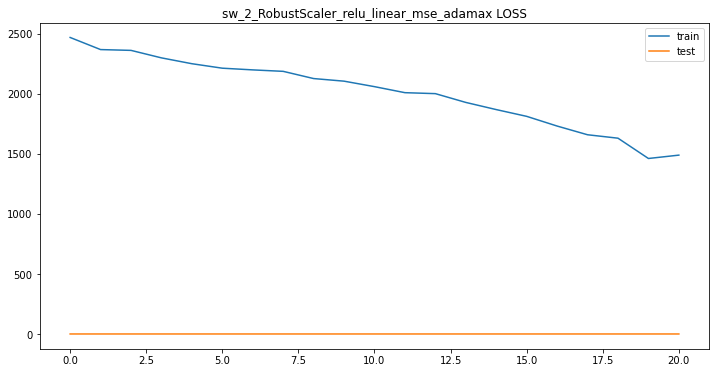


 sw_2_RobustScaler_relu_linear_mse_adamax 데이터 비교


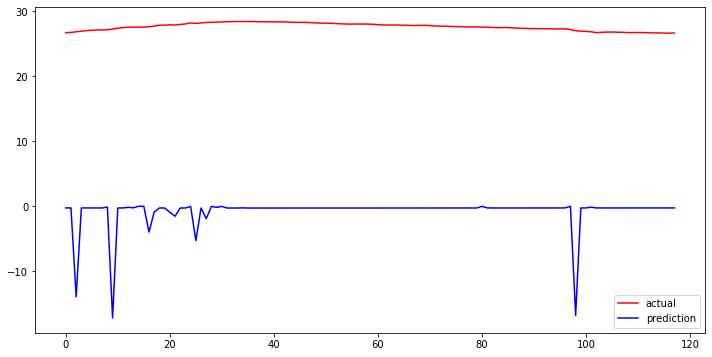

sw_2_RobustScaler_relu_linear_mse_adamax model_prediction이 완료되었습니다.
sw_2_RobustScaler_relu_linear_mse_adamax C001 metrics
mean_squared_error : 28.475345052850656
r2_score : -2604.0992808425895
sw_2_RobustScaler_relu_linear_mse_adamax이 완료되었습니다.
LSTM activation : relu
Dense activation : linear
loss : mse
optimizer : gradient_descent
Model: "sequential_413"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_413 (LSTM)              (None, 90)                33480     
_________________________________________________________________
dropout_389 (Dropout)        (None, 90)                0         
_________________________________________________________________
dense_413 (Dense)            (None, 1)                 91        
Total params: 33,571
Trainable params: 33,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10/10 - 1s - loss: nan - acc: 0.0

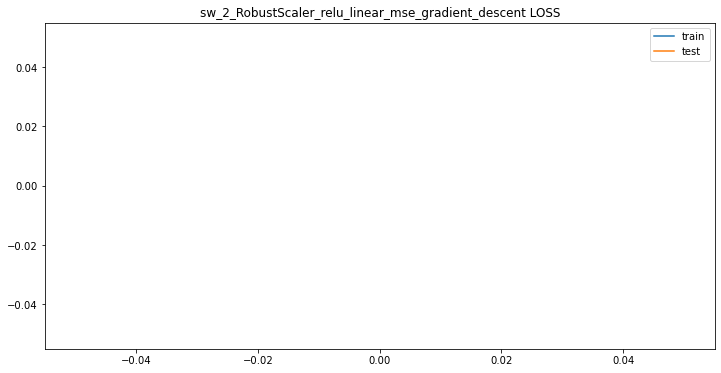


 sw_2_RobustScaler_relu_linear_mse_gradient_descent 데이터 비교


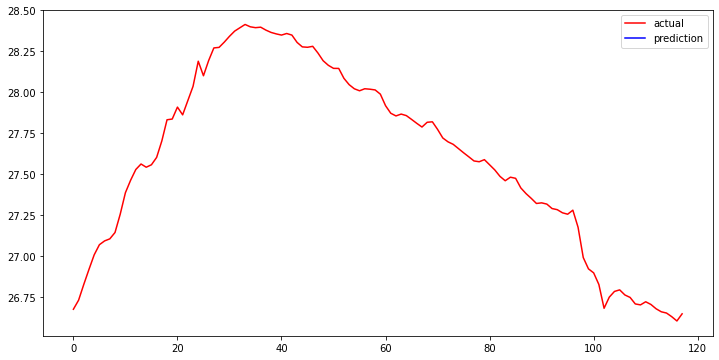

sw_2_RobustScaler_relu_linear_mse_gradient_descent model_prediction이 완료되었습니다.
sw_2_RobustScaler_relu_linear_mse_gradient_descent C001 metrics


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# result_df = pd.DataFrame()
# result_df = pd.concat([result_df, trans_df[['_date']]], axis=1)

for i in trans_df.columns[1:9]:
    global spot
    spot = i
    
    # 가장 큰 null 기간값을 기준으로 위, 아래 데이터 비교
    upper_data = trans_df[['_date', i, 'rain']][(trans_df._date >= pd.Timestamp(date_df.loc[0, f'{i}_start'])) & (trans_df._date <= pd.Timestamp((date_df[f'{i}_finish'][date_df[f'{i}_null'] == date_df[f'{i}_null'].max()]).values[0]))]
    lower_data = trans_df[['_date', i, 'rain']][trans_df._date >= pd.Timestamp(date_df.loc[(date_df[f'{i}_finish'][date_df[f'{i}_null'] == date_df[f'{i}_null'].max()].index + 1), f'{i}_start'].values[0])]

    upper_data[[i]] = upper_data[[i]].interpolate(method='linear')
    lower_data[[i]] = lower_data[[i]].interpolate(method='linear')

    # 윗 데이터가 아래보다 크고
    if len(upper_data) >= len(lower_data):
        # 1년 이상이면 프로세스 시작
        if len(upper_data) >= 365:
            train_df = set_params(upper_data.iloc[:, 1:])
            test_df = set_params(lower_data.iloc[:, 1:])
            split_data(train_df, test_df)

        # 아닐 경우 경고문 출력
        else:
            print('Data are too short')
    
    # 아랫 데이터가 윗 데이터보다 크고
    elif len(upper_data) < len(lower_data):
        # 365일 이상이면 프로세스 시작
        if len(lower_data) >= 365:
            train_df = lower_data.iloc[:, 1:]
            test_df = upper_data.iloc[:, 1:]
            split_data(train_df, test_df)

        else:
            print('Data are too short')

##################################################

## 새로운 데이터 적용

In [ ]:
# 모델 불러오고, 각각 예측
def prediction():
  targetname = '/content/drive/MyDrive/soda/HS_woNaN.csv' # input("예측 데이터 경로(선택. 없을 시 통과) :")

  global n_shift
  n_shift = 1 # int(input("데이터 이동 횟수 :")) + 1

  # 모델 불러오기
  # 경로
  DIR = '/content/drive/MyDrive/soda/models/test/{0}/{1}/'.format(spot, str(n_shift))

  # 모델 정보
  modelname = os.listdir(DIR)

  # 모델 정보
  print('저장된 모델 :\n')
  for i, file in enumerate(modelname):
      print('{}  {}'.format(i, file.ljust(30)))

  # 적용을 원하는 모델 번호 입력(a : 전체 모델)
  models_num = list(input("원하는 모델 번호(공백으로 구분, a : 전체) : ").split(' '))
  
  # 모델을 적용할 새 데이터 불러오기
  target_data = pd.read_csv(targetname, encoding = 'cp949', parse_dates=["date"])
  display(target_data.info())

  # 데이터 shift
  shifted_target = trans_dates(target_data)
  display(shifted_target)

  # 예측에 사용될 데이터 분리
  shifted_target = shifted_target.values
  target = shifted_target[:, :-1]
  target_X = shifted_target[:, :-2]
  target_X = target_X.reshape((target_X.shape[0], 1, target_X.shape[1]))

  metrics_dict = {}

  # 원본 데이터, 예측 데이터 비교를 위한 리스트
  data = []

  # 원본 데이터 추가
  data.append(shifted_target[:, -1])

  # 선택된 모델 적용
  for i in models_num:

    # 전체 모델
    if i == 'a':
      for j in modelname:
        model = load_model(DIR + j)
        print(j)

        # 모델 정보 출력
        model.summary()

        # 예측 및 예측값 출력
        data.append(model_prediction(target_X, target, model, '예측 데이터', metrics_dict, nname=j))

   # 일부 선택된 모델
    else:  
      model = load_model(DIR + modelname[int(i)])
      print(modelname[int(i)])
      model.summary()
      data.append(model_prediction(target_X, target, model, '예측 데이터', metrics_dict, nname=modelname[int(i)]))

  dict_to_frame(metrics_dict)

  # 결과값 출력
  result = pd.DataFrame(metrics_dict.values(), index = shifted_target.index, columns = ['act', 'pred'])

  return result

In [ ]:
def start_shift():
  # 개인 설정 모델 이름, shift 횟수, 원본 데이터는 global 변수 설정
  global modelname, n_shift, model_data

  # 파일 이름(경로 입력)
  filename = '/content/drive/MyDrive/soda/지하수수위.csv' # input("학습 데이터 경로 :")

  # 개인 설정 모델 이름 입력
  modelname = 'sw' # input("저장할 모델 이름 : ")

  # shift 횟수 입력(1번을 해도 함수에는 2로 입력되기 때문에 + 1)
  n_shift = int(input("데이터 이동 횟수 :")) + 1

  # 파일 불러오기(날짜 데이터 형식에 맞춤)
  model_data = pd.read_csv(filename, encoding = 'euc-kr', parse_dates=["date"])

  # 파일 정보 출력
  display(model_data.info())

  trans = trans_dates(model_data)

  # shift된 데이터 출력
  display(trans)

  split_data(trans)